# Robot Simulation

In [1]:
from jyro.simulator import (Robot, Pioneer, Pioneer16Sonars, 
                            PioneerFrontLightSensors, Camera,
                            VSimulator)
import random
import numpy as np

In [2]:
robot = Pioneer("Pioneer", 3.5, 2, 0)

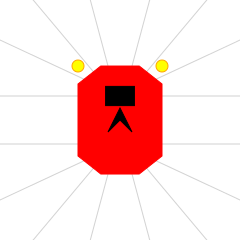

In [3]:
robot.addDevice(Pioneer16Sonars())
robot.addDevice(Camera())
light_sensors = PioneerFrontLightSensors(3.0)
light_sensors.lightMode = 'ambient'
robot.addDevice(light_sensors)

In [4]:
def worldf(physics):
    physics.addBox(0, 0, 4, 4, fill="backgroundgreen", wallcolor="gray")
    physics.addLight(2, 0.75, 1.0) # increased brightness for new linear version of lights

In [5]:
sim = VSimulator(robot, worldf)

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='248px', padding='0px 0px 0px 0px', width='10px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="240" version="1.1" width="240" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="240.0" stroke="#bebebe" stroke-width="1" width="240.0" x="0.0" y="0.0" /><circle cx="120.0" cy="195.0" fill="#ffff00" r="15.0" stroke="#ffff00" stroke-width="1" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="109.80000000000001" y2="16.07215199999999" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.77724019461742" y1="107.99999999999999" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="106.5" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="106.5" y2="5.734632000000062" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="107.99999999999999" y2="80.11296600000001" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="109.80000000000001" y2="100.007538" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="130.2" y2="139.992462" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="132.0" y2="159.88703399999997" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="133.5" y2="234.26536799999994" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="133.5" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.7772401946174" y1="132.0" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="130.2" y2="223.927848" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="2.1539193796210117" y1="120.0" y2="0.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="240.0" y1="120.0" y2="102.67948799999999" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="199.5" y1="195.0" y2="106.5" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="220.5" y1="195.0" y2="106.5" /><polygon fill="red" points="205.2,106.5 199.5,111.0 199.5,129.0 205.2,133.5 214.8,133.5 220.5,129.0 220.5,111.0 214.8,106.5" stroke="red" stroke-width="1" /><polygon points="-3.0,-3.0 0,0 3.0,-3.0 0,3.0" stroke="black" stroke-width="1" transform="translate(210.0,120.0) rotate(180.0)" /><polygon fill="black" points="213.6,111.6 213.6,116.39999999999999 206.4,116.39999999999999 206.4,111.6" stroke="black" stroke-width="1" /><circle cx="199.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /><circle cx="220.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='30px', padding='0px 0px 0px 10px', width='260px'), readout=False))), VBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00<\x00\x00\x00(\x08\x02\x00\x00\x00-\xd9\x0e\xa8\x00\x00\x00\xf6IDATx\x9c\xed\xd6\xaf\x0b\xc2@\x14\xc0\xf1\xf7\xee\xdd\xfev\xcb\xa2\xc5\x81`\x11\x86\xa0e0\x8bAA\x83A\x8bA\x8b\xc1b\x12\x8b\xc94\xc3\xa9\xccMn:\x8f7\x0f\xd

In [6]:
camera = robot.device["camera"]

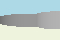

In [7]:
image = camera.getImage()
image

In [8]:
image.size

(60, 40)

In [9]:
data = camera.getData()
data.shape

(40, 60, 3)

In [10]:
robot.move(0.50, 0.35)

In [11]:
sim.step()

In [12]:
def random_action():
    """Generate a random action from a limited set of possible settings"""
    possible = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return [random.choice(possible), random.choice(possible)]

def get_senses(robot):
    light = robot["light"].getData()
    sonar = [v/3.0 for v in robot["sonar"].getData()]
    camera = robot["camera"].getData()
    return [light, sonar, camera]

In [13]:
senses = get_senses(robot)
list(map(len, senses))

[2, 16, 40]

In [14]:
def brain(robot):
    senses = get_senses(robot)
    net.propagate(senses)
    translate, rotate = random_action()
    #self.move(translate, rotate)
    robot.move(0.50, 0.35)

In [15]:
robot.brain = brain

In [16]:
from conx import Network, Layer, FlattenLayer, SGD, ImageLayer, Conv2DLayer
import numpy as np

conx, version 3.2.1
Using Theano backend.


In [17]:
net = Network("Robot Prediction Network")
net.add(Layer("light", 2))
net.add(Layer("sonar", 16))
net.add(ImageLayer("camera", (40,60), 3))
net.add(FlattenLayer("flatten"))
net.add(Conv2DLayer("conv", 16, (3,3)))
net.add(Layer("hidden", 50, activation="relu"))
net.add(Layer("output1", 2, activation="sigmoid"))
net.add(Layer("hidden2", 5, activation="sigmoid"))
net.add(Layer("hidden3", 10, activation="sigmoid", dropout=0.25))
net.add(Layer("hidden4", 10, activation="sigmoid"))
net.add(Layer("output2", 5, activation="sigmoid"))

In [18]:
net.connect("sonar", "hidden2")
net.connect("light", "hidden")
net.connect("camera", "conv")
net.connect("conv", "flatten")
net.connect("flatten", "hidden2")
net.connect("hidden", "hidden2")
net.connect("hidden2", "hidden3")
##net.connect("hidden2", "output2")
net.connect("hidden3", "output2")
net.connect("hidden3", "hidden4")
net.connect("hidden4", "output1")

In [19]:
net.compile(optimizer="adam", error="mse")
net.config["hspace"] = 200

<IPython.core.display.Javascript object>

<Network name='Robot Prediction Network' (compiled)>
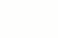
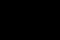

In [20]:
net

In [21]:
matrix = net.propagate_to("conv", get_senses(robot))

In [22]:
net["conv"].feature = 6


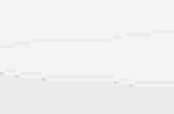
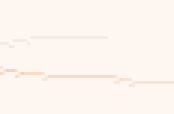
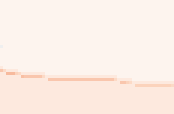
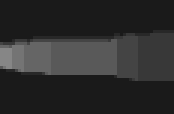
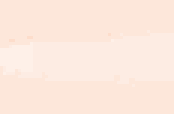
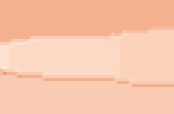
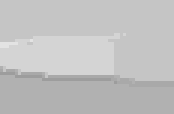
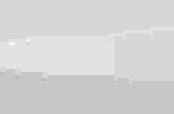
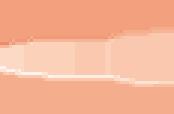
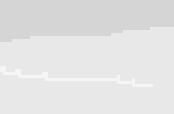
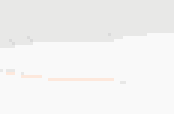
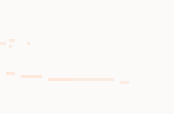
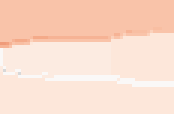
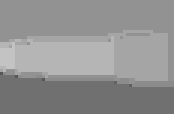
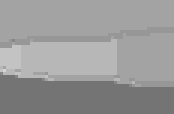
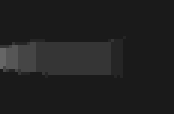

In [23]:
net.propagate_to_features("conv", get_senses(robot), scale=3)

In [24]:
net.dashboard()

<IPython.core.display.Javascript object>

Tab(children=(VBox(children=(HTML(value='<p style="text-align:center"><svg id=\'Robot Prediction Network\' xmlns=\'http://www.w3.org/2000/svg\' viewBox="0 0 1100 664" height="780" image-rendering="pixelated">\n    <defs>\n        <marker id="arrow" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto" markerUnits="strokeWidth">\n          <path d="M0,0 L0,6 L9,3 z" fill="black" />\n        </marker>\n    </defs><text x="550.0" y="12.5" font-family="monospace" font-size="15" text-anchor="middle" alignment-baseline="central">Robot Prediction Network</text><rect x="315.6666666666667" y="29" width="102" height="52" style="fill:none;stroke:black;stroke-width:2"/><image id="Robot Prediction Network_output1_12" class="Robot Prediction Network_output1" x="316.6666666666667" y="30" height="50" width="100" preserveAspectRatio="none" href="data:image/gif;base64,R0lGODdhAgABAIcAANhlUeDg4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAAgABAAAIBQADAAgIADs="><title>Layer: output1 (output)\n shape = (2,)\n Keras class = Dense\n activation = sigmoid</title></image><text x="421.6666666666667" y="57.0" font-family="monospace" font-size="12" text-anchor="start" alignment-baseline="central">output1</text><rect x="632.3333333333334" y="29" width="202" height="42" style="fill:none;stroke:black;stroke-width:2"/><image id="Robot Prediction Network_output2_13" class="Robot Prediction Network_output2" x="633.3333333333334" y="30" height="40" width="200" preserveAspectRatio="none" href="data:image/gif;base64,R0lGODdhBQABAIcAAP3j062trfi/o+np6QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAABQABAAAICAAHAAgAQEBAADs="><title>Layer: output2 (output)\n shape = (5,)\n Keras class = Dense\n activation = sigmoid</title></image><text x="838.3333333333334" y="52.0" font-family="monospace" font-size="12" text-anchor="start" alignment-baseline="central">output2</text><line x1="366.6666666666667" y1="109" x2="366.6666666666667" y2="82" stroke="black" stroke-width="2" marker-end="url(#arrow)"><title>Weights from hidden4 to output1\n output1/kernel has s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Network name='Robot Prediction Network' (compiled)>
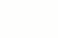
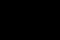

In [28]:
net